<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 10px; margin: 10px 0;">

# 📈 Empirical Analysis of Market Capitalization Weighted Index (MWI) vs. Equal Weighted Index (EWI) Performance for S&P 500

<p style="font-size: 18px;">This notebook presents an empirical analysis of the performance of Market Capitalization Weighted Indexing (MWI) and Equal Weighted Indexing (EWI) strategies applied to a subset of the S&P 500. The objective is to explore why the EWI strategy often outperforms the MWI strategy.</p>

<p style="font-size: 18px;">For the sake of stability and simplicity in this analysis, we are working with the 411 companies that have continuously been part of the S&P 500 from January 2006 to August 2023. This eliminates any effects due to companies entering or leaving the index during this period.</p>

<p style="font-size: 18px;">We begin by fetching the necessary data for these companies using open-source Python package like `yfinance` and web scraping techniques. All the data used in this analysis is freely available and no proprietary or paid sources were used.</p>

<p style="font-size: 18px;">Next, we build MWI and EWI portfolios from this data, calculating returns and other relevant metrics. Please note that we do not consider transaction fees in these custom portfolios to avoid additional complexity. Furthermore, for the rebalancing of both portfolios, we perform it after the close of the third Friday in March, June, September, and December.</p>

<p style="font-size: 18px;">Through exploratory data analysis, we delve into the distribution characteristics of individual stock returns, focusing on their skewness as a potential explanatory factor for the observed performance difference. We also visualize various aspects of our portfolios to better understand their composition and performance over time.</p>

<p style="font-size: 20px; font-weight: bold; text-align: center;">Let's begin!</p>

<img src="stock.jpg" alt="Image Description" style="max-width:100%; height:auto;">

</div>


---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

## 📈 Step 1: Fetching the Tickers of S&P 500 Constituents

<p style="font-size: 16px;">The function <code>get_sp500_tickers()</code> fetches the ticker symbols of all companies that are currently constituents of the S&P 500 index.</p>

<p style="font-size: 16px;">This is done by web scraping the Wikipedia page that lists the S&P 500 constituents. We are using the pandas <code>read_html</code> function which conveniently fetches tabular data from an HTML page and returns it in the form of a DataFrame. After fetching the data, we just extract the ticker symbols and return them as a list.</p>

</div>

---


In [176]:
import pandas as pd 

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)
    df = table[0]
    return list(df.Symbol)

<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">After running this function, we will have a list of ticker symbols for all current S&amp;P 500 constituents stored in the `tickers` variable.</span>
</div>


In [177]:
tickers = get_sp500_tickers()

In [178]:
sorted(tickers)[:10]

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE']

---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

## 📊 Step 2: Fetching Historical Market Capitalization Data 

<p style="font-size: 16px;">To construct our <strong>Market Capitalization Weighted Index (MWI)</strong>, we need to collect historical daily market capitalization data for each constituent of the S&P 500. Sourcing this type of data can often be challenging due to access restrictions and cost constraints. After thorough exploration, I found a freely available API endpoint on StockAnalysis.com that supplies this precise information.</p>

<p style="font-size: 16px;">This endpoint was discovered by examining the Network tab in the browser's Developer Tools while interacting with the <code>stockanalysis.com</code> website. This allowed us to observe the API calls made by the web application.</p>

<p style="font-size: 16px;">The API endpoint we identified is <code>https://stockanalysis.com/api/symbol/s/{symbol}/marketcap?t=price</code>, where <code>{symbol}</code> is the ticker symbol of a stock we're interested in. This API call returns a JSON object with a <code>status</code> field, indicating the success or failure of the request, and a <code>data</code> field containing the actual market cap data. The <code>data</code> field is an array of arrays, where each inner array consists of a Unix timestamp (representing the date) and the market cap for the specified stock on that date.</p>

<p style="font-size: 16px;">To effectively gather data for all the stocks in our list, I implemented a concurrent fetching system using the <code>concurrent.futures</code> module. This system allows us to send multiple API requests simultaneously, significantly reducing the total time required to gather all our necessary data.</p>

<p style="font-size: 16px;">In the following code, we will pull historical market capitalization data for all currently listed stocks in the S&P 500 index.</p>

</div>

---


In [180]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tenacity import retry, stop_after_attempt, wait_fixed

@retry(stop=stop_after_attempt(3), wait=wait_fixed(1))
def get_market_cap(symbol):
    url = f"https://stockanalysis.com/api/symbol/s/{symbol}/marketcap?t=price"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    return pd.DataFrame({
        'Date': [pd.to_datetime(x[0], unit='ms') for x in data['data']],
        f'Market Cap {symbol}': [x[1] for x in data['data']]
    })

def get_market_caps(tickers):
    first_ticker = tickers.pop(0)
    master_df = get_market_cap(first_ticker)

    with ThreadPoolExecutor(max_workers=3) as executor:
        future_to_ticker = {executor.submit(get_market_cap, ticker): ticker for ticker in tickers}
        for future in as_completed(future_to_ticker):
            ticker = future_to_ticker[future]
            try:
                df = future.result()
                master_df = master_df.merge(df, on='Date', how='outer')
            except Exception as e:
                print(f"Error occurred while getting market cap data for {ticker}: {e}")

    return master_df

In [181]:
data = get_market_caps(tickers)

In [182]:
data.set_index('Date', inplace=True)

In [183]:
data.head()

,Market Cap MMM,Market Cap AOS,Market Cap ABBV,Market Cap ABT,Market Cap ATVI,Market Cap ACN,Market Cap ADM,Market Cap ADP,Market Cap ADBE,Market Cap AAP,...,Market Cap WMB,Market Cap GWW,Market Cap WYNN,Market Cap XYL,Market Cap XEL,Market Cap YUM,Market Cap ZBRA,Market Cap ZION,Market Cap ZBH,Market Cap ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-01,3.266150e+10,610000000.0,NaN,7.266370e+10,NaN,NaN,NaN,2.330110e+10,3.018500e+09,NaN,...,1.221720e+10,4.106500e+09,NaN,NaN,NaN,7.022000e+09,1.046800e+09,4.022400e+09,NaN,NaN
1998-12-02,3.248490e+10,612800000.0,NaN,7.418130e+10,NaN,NaN,NaN,2.398090e+10,2.957000e+09,NaN,...,1.219150e+10,4.095200e+09,NaN,NaN,NaN,6.936400e+09,1.044900e+09,4.100600e+09,NaN,NaN
1998-12-03,3.188290e+10,611400000.0,NaN,7.266370e+10,NaN,NaN,NaN,2.284800e+10,3.018500e+09,NaN,...,1.171240e+10,4.112200e+09,NaN,NaN,NaN,7.098400e+09,1.039000e+09,4.171000e+09,NaN,NaN
1998-12-04,3.220800e+10,612800000.0,NaN,7.550170e+10,NaN,NaN,NaN,2.339480e+10,2.965400e+09,NaN,...,1.176370e+10,4.207200e+09,NaN,NaN,NaN,7.537400e+09,1.039000e+09,4.257000e+09,NaN,NaN
1998-12-07,3.092770e+10,598400000.0,NaN,7.550170e+10,NaN,NaN,NaN,2.358210e+10,3.064200e+09,NaN,...,1.173810e+10,4.142600e+09,NaN,NaN,NaN,7.547800e+09,1.062400e+09,4.261700e+09,NaN,NaN


---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

## 🧹 Step 3: Data Cleaning

<p style="font-size: 16px;"><span style="color:blue; font-style: italic;">Insight:</span> In this phase, our primary goal is to scrutinize and tidy up our dataset. By analyzing the count of non-NaN values for each year, we gain insight into the number of companies present in our dataset for each respective year.</p>

</div>

---


In [242]:
import numpy as np
non_zero_counts = data.groupby(data.index.year).count().replace(0, np.nan).apply(lambda x: x.notnull().sum(), axis=1)
non_zero_counts

Date
1998    334
1999    349
2000    363
2001    384
2002    388
2003    393
2004    405
2005    412
2006    418
2007    427
2008    431
2009    435
2010    444
2011    450
2012    457
2013    468
2014    476
2015    483
2016    485
2017    489
2018    494
2019    498
2020    500
2021    501
2022    502
2023    503
dtype: int64

<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">:</span> <span style="color:blue; font-style: italic;">Starting from 2006 offers a comprehensive perspective because it provides over a decade of data coverage and represents more than 83% of the current S&P 500 companies.</span>
</div>


In [273]:
data_2006 = data[data.index.year >= 2006]

data_2006.head()

,Market Cap MMM,Market Cap AOS,Market Cap ABBV,Market Cap ABT,Market Cap ATVI,Market Cap ACN,Market Cap ADM,Market Cap ADP,Market Cap ADBE,Market Cap AAP,...,Market Cap WMB,Market Cap GWW,Market Cap WYNN,Market Cap XYL,Market Cap XEL,Market Cap YUM,Market Cap ZBRA,Market Cap ZION,Market Cap ZBH,Market Cap ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,6.011830e+10,1.108900e+09,NaN,6.135110e+10,3.815300e+09,2.519420e+10,1.592450e+10,2.671390e+10,1.903380e+10,4.707900e+09,...,1.369510e+10,6.421500e+09,5.369300e+09,NaN,7.481600e+09,1.323310e+10,3.013200e+09,6.893400e+09,1.696730e+10,NaN
2006-01-04,5.981430e+10,1.114800e+09,NaN,6.144420e+10,3.861800e+09,2.533180e+10,1.693040e+10,2.680040e+10,1.898440e+10,4.741400e+09,...,1.378100e+10,6.393700e+09,5.359300e+09,NaN,7.517900e+09,1.334640e+10,2.983600e+09,6.942100e+09,1.712840e+10,NaN
2006-01-05,5.926710e+10,1.104300e+09,NaN,6.223530e+10,3.894600e+09,2.552100e+10,1.652540e+10,2.657550e+10,1.881140e+10,4.764100e+09,...,1.363770e+10,6.384800e+09,5.327500e+09,NaN,7.513900e+09,1.391530e+10,2.992100e+09,7.005200e+09,1.694750e+10,NaN
2006-01-06,5.975350e+10,1.142300e+09,NaN,6.342970e+10,4.075300e+09,2.651300e+10,1.701530e+10,2.680610e+10,1.927100e+10,4.758700e+09,...,1.368930e+10,6.669200e+09,5.378200e+09,NaN,7.542100e+09,1.387570e+10,3.103900e+09,7.078200e+09,1.686080e+10,NaN
2006-01-09,6.004990e+10,1.181100e+09,NaN,6.578760e+10,4.037000e+09,2.643640e+10,1.722430e+10,2.673690e+10,1.896460e+10,4.820400e+09,...,1.391280e+10,6.722000e+09,5.632000e+09,NaN,7.521900e+09,1.398330e+10,3.151000e+09,7.019600e+09,1.745790e+10,NaN


<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">Data Cleanup Process</span><br>
    For each distinct year in the dataset, columns containing only NaN values are identified and removed.
</div>

In [274]:
years = data_2006.index.year.unique()
for year in years:
    df_year_only = data_2006[data_2006.index.year == year]

    cols_to_drop = df_year_only.columns[df_year_only.isna().all()]
    data_2006 = data_2006.drop(columns=cols_to_drop, errors='ignore')

data_2006=  data_2006.iloc[:-1]

---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 💹 Step 4: Yahoo Finance Data Integration

<p style="font-size: 16px;">Here's what we're doing in this step:</p>

1. **Ticker Cleaning**: 
   <div style="margin-left: 20px">Ensuring tickers are Yahoo Finance compatible.</div>
   
2. **Ticker Conversion**: 
   <div style="margin-left: 20px">Extracting and converting tickers from the dataset's columns for querying.</div>

3. **Date Range**: 
   <div style="margin-left: 20px">Establishing the date range using the min and max dates from the dataset.</div>

4. **Yahoo Finance Query**: 
   <div style="margin-left: 20px">Fetching price data for our tickers within the specified date range using `yfinance`.</div>

5. **DataFrame Prep**: 
   <div style="margin-left: 20px">Adjusting the column structure of our dataset for the integration with the Yahoo Finance data.</div>

6. **Data Merge**: 
   <div style="margin-left: 20px">Concatenating the Yahoo Finance data with our market data dataset.</div>

</div>

---


In [275]:
import yfinance as yf
from datetime import timedelta

tickers = [col.replace('Market Cap ', '') for col in data_2006.columns]
tickers = [ticker.replace("BF.B", "BF-B").replace("BRK.B", "BRK-B") for ticker in tickers]
tickers_str = ' '.join(tickers)

start_date = data_2006.index.min() 
end_date = data_2006.index.max()

yf_data = yf.download(tickers_str, start=start_date, end=end_date, group_by='ticker')

df_copy = data_2006.copy() 
df_copy.columns = pd.MultiIndex.from_product([tickers, ['Market Cap']])


merged_data = pd.concat([yf_data, df_copy], axis=1)


[*********************100%***********************]  418 of 418 completed


In [276]:
merged_data = merged_data.sort_index(axis=1)
merged_data.head()

A                                                 \
            Adj Close      Close       High        Low    Market Cap   
Date                                                                   
2006-01-03  20.400558  23.962805  24.020029  23.476395  1.655500e+10   
2006-01-04  20.455360  24.027182  24.198856  23.869814  1.659940e+10   
2006-01-05  20.991268  24.656652  24.656652  23.927038  1.703430e+10   
2006-01-06  21.100874  24.785408  24.885551  24.384834  1.712330e+10   
2006-01-09  21.039980  24.713877  24.892704  24.620888  1.707390e+10   

                                        AAP                        ...  \
                 Open     Volume  Adj Close      Close       High  ...   
Date                                                               ...   
2006-01-03  23.891273  5307088.0  38.423599  43.520000  43.849998  ...   
2006-01-04  23.998569  4195817.0  38.697296  43.830002  44.709999  ...   
2006-01-05  23.927038  4835402.0  38.882702  44.040001  44.189999  ...   
2006-01-06  24.678112  6146307.0  38.838554  43.990002  44.139999  ...   
2006-01-09  24.785408  4082859.0  39.341816  44.560001  44.740002  ...   

                    ZBRA                            ZION             \
              Market Cap       Open    Volume  Adj Close      Close   
Date                                                                  
2006-01-03  3.013200e+09  42.799999  618800.0  57.059311  76.480003   
2006-01-04  2.983600e+09  42.939999  444300.0  57.462208  77.019997   
2006-01-05  2.992100e+09  42.380001  313000.0  57.984455  77.720001   
2006-01-06  3.103900e+09  42.700001  617100.0  58.588760  78.529999   
2006-01-09  3.151000e+09  44.290001  310700.0  58.103821  77.879997   

                                                                     
                 High        Low    Market Cap       Open    Volume  
Date                                                                 
2006-01-03  76.519997  75.129997  6.893400e+09  75.820000  663700.0  
2006-01-04  77.230003  76.370003  6.942100e+09  76.440002  523100.0  
2006-01-05  77.830002  76.970001  7.005200e+09  76.970001  535800.0  
2006-01-06  78.650002  77.519997  7.078200e+09  77.900002  544600.0  
2006-01-09  78.309998  77.559998  7.019600e+09  78.220001  639700.0  

[5 rows x 2926 columns]

In [277]:
merged_data.tail()

A                                                    \
             Adj Close       Close        High         Low    Market Cap   
Date                                                                       
2023-08-01  122.480003  122.480003  123.580002  120.459999  3.617760e+10   
2023-08-02  127.709999  127.709999  128.729996  121.510002  3.772240e+10   
2023-08-03  125.050003  125.050003  127.360001  124.970001  3.693670e+10   
2023-08-04  126.300003  126.300003  127.169998  125.080002  3.730600e+10   
2023-08-07         NaN         NaN         NaN         NaN  3.736800e+10   

                                         AAP                        ...  \
                  Open     Volume  Adj Close      Close       High  ...   
Date                                                                ...   
2023-08-01  121.779999  1655000.0  73.720001  73.720001  74.250000  ...   
2023-08-02  122.000000  2654700.0  69.639999  69.639999  73.059998  ...   
2023-08-03  127.300003  1742600.0  72.029999  72.029999  72.050003  ...   
2023-08-04  125.440002  1819500.0  71.010002  71.010002  72.019997  ...   
2023-08-07         NaN        NaN        NaN        NaN        NaN  ...   

                    ZBRA                              ZION             \
              Market Cap        Open     Volume  Adj Close      Close   
Date                                                                    
2023-08-01  1.307950e+10  245.020004  2621700.0  37.099998  37.099998   
2023-08-02  1.238020e+10  250.100006  1317300.0  36.630001  36.630001   
2023-08-03  1.281150e+10  238.089996  1170100.0  37.410000  37.410000   
2023-08-04  1.290700e+10  249.000000   569700.0  37.919998  37.919998   
2023-08-07  1.274370e+10         NaN        NaN        NaN        NaN   

                                                                      
                 High        Low    Market Cap       Open     Volume  
Date                                                                  
2023-08-01  38.680000  36.529999  5.494500e+09  38.650002  3265200.0  
2023-08-02  37.000000  35.779999  5.424900e+09  36.169998  3049500.0  
2023-08-03  37.529999  36.110001  5.540400e+09  36.500000  2413900.0  
2023-08-04  38.560001  37.029999  5.617700e+09  37.270000  2443800.0  
2023-08-07        NaN        NaN  5.650300e+09        NaN        NaN  

[5 rows x 2926 columns]

In [281]:
merged_data = merged_data[merged_data.index < '2023-08-07']



<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">Identifying Missing Data</span><br>
    We extract and identify the exact locations of NaN values in our dataset. The output is a DataFrame that provides detailed coordinates (Date, Ticker, and Attribute) of each missing value.
</div>

In [283]:
list(nan_locations_df["Attribute"].unique())

['CMG', 'FSLR', 'HWM', 'LDOS', 'MA', 'TDG', 'UAL', 'IVZ']

<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span><span style="color:blue; font-weight: bold;"></span><br>
    Now we remove columns from our dataset that have been identified to contain missing values.
</div>

In [284]:
merged_data = merged_data.drop(list(nan_locations_df["Attribute"].unique()), level=0, axis=1)

In [258]:

list(nan_locations_df["Attribute"].unique())

['CMG', 'FSLR', 'LDOS', 'MA', 'TDG', 'UAL', 'IVZ']

In [289]:
stocks = merged_data.columns.get_level_values(0).unique()
len(stocks)


410

<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">Note:</span> <span style="color:blue; font-style: italic;">There's a discrepancy in the number of companies reported for 2006 pre and post data cleaning. This is due to Partial Data. During our initial aggregation, companies with minimal data points for 2006 were included. However, post-cleaning, companies lacking substantial data coverage for the entire year were filtered out, leading to the reduced count. This ensures our dataset only includes companies with data uniformly spread over the years.</span>
</div>


---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 📊 Step 5: Designing Equally-Weighted and Market-Capitalized ETF Portfolios

<p style="font-size: 16px;">This step delves into the construction of two distinct ETF portfolio strategies: <strong>EWI</strong> (Equal Weighted Index) and <strong>MWI</strong> (Market Weighted Index). The meticulous planning of these strategies demands various stages, including the computation of initial weights, the establishment of a rebalancing calendar, calculation of daily returns, and the culminating evaluation of the portfolio’s cumulative returns.</p>

1. **Initial Weights Assignment**: 
   <div style="margin-left: 20px">Setting up the portfolio weights for our two strategies: EWI and MWI.</div>
   
2. **Rebalancing Calendar**: 
   <div style="margin-left: 20px">Identifying specific dates, notably the third Friday of March, June, September, and December, as our strategic rebalancing points.</div>

3. **Rebalancing Logic**: 
   <div style="margin-left: 20px">Adjusting the weights of the assets in our portfolio based on the strategies. EWI is uniformly re-adjusted, while MWI is recalibrated according to the latest market caps.</div>

4. **Daily Return Calculation**: 
   <div style="margin-left: 20px">Computing daily returns for every ticker, based on their closing prices.</div>

5. **Portfolio Returns Computation**: 
   <div style="margin-left: 20px">Aggregating the ticker returns into portfolio returns for both EWI and MWI strategies.</div>

6. **Cumulative Return Analysis**: 
   <div style="margin-left: 20px">Assessing the overall performance of our strategies over time, by observing its growth.</div>

</div>

---


In [290]:
import pandas as pd
import numpy as np

data_copy = merged_data.copy()
data_copy=  data_copy.iloc[:-1]
tickers = data_copy.columns.get_level_values(0).unique()

weights_ewi = pd.DataFrame(index=data_copy.index, columns=tickers)
weights_mwi = pd.DataFrame(index=data_copy.index, columns=tickers)

weights_ewi.iloc[0] = 1 / len(tickers)
total_market_cap = data_copy.iloc[0].xs('Market Cap', level=1).sum()
weights_mwi.iloc[0] = data_copy.iloc[0].xs('Market Cap', level=1) / total_market_cap

third_fridays = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='WOM-3FRI')
rebalance_dates = third_fridays[third_fridays.month.isin([3, 6, 9, 12])]
rebalance_dates = rebalance_dates.intersection(data_copy.index)

for date in rebalance_dates:
    if date > weights_ewi.index.min():
        weights_ewi.loc[date] = 1 / len(tickers)
        market_caps = data_copy.loc[date].xs('Market Cap', level=1)
        total_market_cap = market_caps.sum()
        weights_mwi.loc[date] = market_caps / total_market_cap

weights_ewi = weights_ewi.fillna(method='ffill')
weights_mwi = weights_mwi.fillna(method='ffill')

for ticker in tickers:
    data_copy[(ticker, 'Return')] = data_copy[(ticker, 'Close')].pct_change()

data_copy[('EWI', 'Return')] = (data_copy.xs('Return', axis=1, level=1) * weights_ewi).sum(axis=1)
data_copy[('MWI', 'Return')] = (data_copy.xs('Return', axis=1, level=1) * weights_mwi).sum(axis=1)
data_copy[('EWI', 'Cumulative Return')] = (1 + data_copy[('EWI', 'Return')]).cumprod() - 1
data_copy[('MWI', 'Cumulative Return')] = (1 + data_copy[('MWI', 'Return')]).cumprod() - 1


C:\Users\Zahra\AppData\Local\Temp\ipykernel_9684\2966458143.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Zahra\AppData\Local\Temp\ipykernel_9684\2966458143.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Zahra\AppData\Local\Temp\ipykernel_9684\2966458143.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [291]:
data_copy.head()

A                                                 \
            Adj Close      Close       High        Low    Market Cap   
Date                                                                   
2006-01-03  20.400558  23.962805  24.020029  23.476395  1.655500e+10   
2006-01-04  20.455360  24.027182  24.198856  23.869814  1.659940e+10   
2006-01-05  20.991268  24.656652  24.656652  23.927038  1.703430e+10   
2006-01-06  21.100874  24.785408  24.885551  24.384834  1.712330e+10   
2006-01-09  21.039980  24.713877  24.892704  24.620888  1.707390e+10   

                                        AAP                        ...  \
                 Open     Volume  Adj Close      Close       High  ...   
Date                                                               ...   
2006-01-03  23.891273  5307088.0  38.423599  43.520000  43.849998  ...   
2006-01-04  23.998569  4195817.0  38.697296  43.830002  44.709999  ...   
2006-01-05  23.927038  4835402.0  38.882702  44.040001  44.189999  ...   
2006-01-06  24.678112  6146307.0  38.838554  43.990002  44.139999  ...   
2006-01-09  24.785408  4082859.0  39.341816  44.560001  44.740002  ...   

                 XOM      XRAY       YUM       ZBH      ZBRA      ZION  \
              Return    Return    Return    Return    Return    Return   
Date                                                                     
2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2006-01-04  0.001710  0.009254  0.008556  0.009492 -0.009806  0.007061   
2006-01-05 -0.004951 -0.011370  0.042630 -0.010560  0.002829  0.009089   
2006-01-06  0.019732  0.015582 -0.002848 -0.005117  0.037385  0.010422   
2006-01-09 -0.000505  0.009863  0.007752  0.035415  0.015186 -0.008277   

                 EWI       MWI               EWI               MWI  
              Return    Return Cumulative Return Cumulative Return  
Date                                                                
2006-01-03  0.000000  0.000000          0.000000          0.000000  
2006-01-04  0.006652  0.004077          0.006652          0.004077  
2006-01-05  0.001467  0.000111          0.008128          0.004189  
2006-01-06  0.010531  0.009869          0.018745          0.014099  
2006-01-09  0.007257  0.003676          0.026138          0.017827  

[5 rows x 3284 columns]

In [292]:
df_portfolio = data_copy.sort_index(axis=1)
df_portfolio.tail()

A                                                    \
             Adj Close       Close        High         Low    Market Cap   
Date                                                                       
2023-07-28  126.050003  126.050003  127.510002  123.160004  3.723210e+10   
2023-07-31  121.769997  121.769997  124.449997  121.220001  3.596790e+10   
2023-08-01  122.480003  122.480003  123.580002  120.459999  3.617760e+10   
2023-08-02  127.709999  127.709999  128.729996  121.510002  3.772240e+10   
2023-08-03  125.050003  125.050003  127.360001  124.970001  3.693670e+10   

                                                   AAP             ...  \
                  Open    Return     Volume  Adj Close      Close  ...   
Date                                                               ...   
2023-07-28  127.250000 -0.004816  3138800.0  73.169998  73.169998  ...   
2023-07-31  124.379997 -0.033955  2376100.0  74.389999  74.389999  ...   
2023-08-01  121.779999  0.005831  1655000.0  73.720001  73.720001  ...   
2023-08-02  122.000000  0.042701  2654700.0  69.639999  69.639999  ...   
2023-08-03  127.300003 -0.020828  1742600.0  72.029999  72.029999  ...   

                ZBRA                  ZION                                   \
              Return     Volume  Adj Close      Close       High        Low   
Date                                                                          
2023-07-28 -0.000835   534100.0  38.689999  38.689999  38.970001  37.840000   
2023-07-31  0.029347   545800.0  38.250000  38.250000  39.110001  37.650002   
2023-08-01 -0.172717  2621700.0  37.099998  37.099998  38.680000  36.529999   
2023-08-02 -0.053460  1317300.0  36.630001  36.630001  37.000000  35.779999   
2023-08-03  0.034833  1170100.0  37.410000  37.410000  37.529999  36.110001   

                                                          
              Market Cap       Open    Return     Volume  
Date                                                      
2023-07-28  5.730000e+09  38.290001  0.028716  2650400.0  
2023-07-31  5.664900e+09  38.919998 -0.011372  6188700.0  
2023-08-01  5.494500e+09  38.650002 -0.030065  3265200.0  
2023-08-02  5.424900e+09  36.169998 -0.012668  3049500.0  
2023-08-03  5.540400e+09  36.500000  0.021294  2413900.0  

[5 rows x 3284 columns]

---

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 📊 Step 6: Visualization of Cumulative Returns MWI vs EWI

<p style="font-size: 16px;">In this step, we employ an interactive visualization to contrast the performances of the two portfolio strategies: <strong>EWI</strong> (Equal Weighted Index) and <strong>MWI</strong> (Market Weighted Index).</p>

<p style="color: blue; font-size: 16px; font-style: italic;">Insight:</p>
<p style="font-size: 16px;">A preliminary observation from the chart showcases that the cumulative return of EWI outpaces that of MWI over the studied period almost all the time. This suggests that the equal allocation strategy (where each asset holds equal weight) has outperformed the market-cap-based one.</p>

</div>

---


In [319]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatter(x=df_portfolio.index, y=df_portfolio[('EWI', 'Cumulative Return')],
                    mode='lines',
                    name='EWI'))

fig.add_trace(go.Scatter(x=df_portfolio.index, y=df_portfolio[('MWI', 'Cumulative Return')],
                    mode='lines',
                    name='MWI'))


fig.update_layout(title='Cumulative Returns of EWI and MWI Portfolios',
                   xaxis_title='Date',
                   yaxis_title='Cumulative Return',
                   template="plotly_dark") 


fig.show()

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 📊 Step 7: Dissecting Weight Distributions: MWI vs EWI

<p style="font-size: 16px;">In this step, we delve into the weight distribution characteristics of the two indexing strategies: <strong>MWI</strong> (Market-Cap Weighted Index) and <strong>EWI</strong> (Equal Weighted Index).</p>

<p style="color: blue; font-size: 16px; font-style: italic;">Insight:</p>
<p style="font-size: 16px;">By understanding the disparity in weight allocation across stocks in these two strategies, we can gain deeper insights into why MWI lag behind EWI.</p>

</div>


In [294]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

def plot_graph(date):
   
    market_caps = df_portfolio.xs('Market Cap', level=1, axis=1).loc[date]

    ranked = market_caps.sort_values(ascending=False)

    cumulative_mwi = (ranked / ranked.sum()).cumsum()

    cumulative_ewi = pd.Series(np.linspace(1/len(ranked), 1, len(ranked)), index=ranked.index)

    percentage_of_constituents = np.linspace(1/len(ranked), 1, len(ranked)) * 100


    fig, ax = plt.subplots(figsize=(12, 8)) 
    
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    
    ax.plot(percentage_of_constituents, cumulative_mwi * 100, label='MWI', color='cyan') 
    ax.plot(percentage_of_constituents, cumulative_ewi * 100, label='EWI', color='magenta')  
    
    ax.set_xlabel('Percentage of Constituents (Ranked by Size)', color='white')
    ax.set_ylabel('Cumulative Index Weight (%)', color='white')
    ax.set_title('Cumulative Index Weight by Constituent Size for ' + date, color='white')
    ax.legend()
    
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='both', colors='white')
    ax.yaxis.label.set_color('white')
    
    ax.grid(True, color='gray')
    
    plt.show()




In [321]:
dates_list = df_portfolio.xs('Market Cap', level=1, axis=1).index.strftime('%Y-%m-%d').tolist()  

_ = interact(plot_graph, date=widgets.SelectionSlider(description='Date', options=dates_list))

interactive(children=(SelectionSlider(description='Date', options=('2006-01-03', '2006-01-04', '2006-01-05', '…

<div style="background-color: #ffffcc; padding: 20px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">📈</span> 
    <span style="color:blue; font-weight: bold;">Differential Weightage Analysis between MWI and EWI</span>
    <p>In the MWI strategy, a mere 10% of the constituent stocks command nearly half of the total index weight, and roughly 30% of the stocks represent around 75% of the index's weight. This suggests that the performance of MWI is significantly influenced by its top stocks.This reveals the pronounced weightage given to the top stocks in MWI, which could lead to performance skewed by these heavyweights</p>

<p>Conversely, in the EWI strategy, every stock holds an equal weight. This means that the bottom 40% of stocks, which contribute about 10% in MWI, have an amplified presence in EWI.</p>

<p><span style="color:blue; font-weight: bold;">Insight:</span> The MWI's performance is predominantly determined by its heavyweight stocks. In contrast, EWI offers balanced exposure, potentially harvesting benefits from smaller stocks that might be sidelined in MWI.</p>
</div>

<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 📊 Distribution Analysis of Cumulative Returns

<p style="font-size: 16px;">The histogram illustrates the distribution of cumulative returns for our subset S&P 500 constituents. What becomes evident is that it's not a normal distribution. Instead, we observe a concentration of stocks with modest returns and a long right tail, signifying a minority of stocks that have exceptionally high returns.</p>

</div>

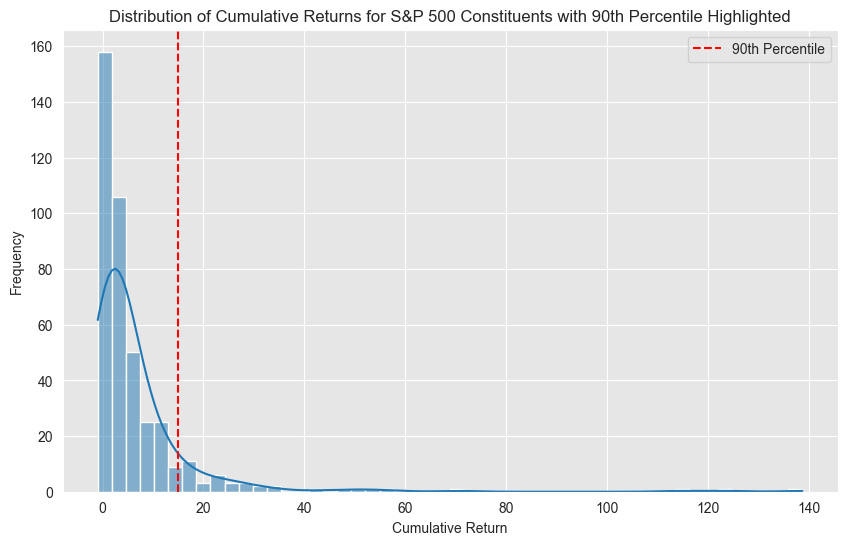

In [317]:
import seaborn as sns

cumulative_returns = (1 + df_portfolio.xs('Return', level=1, axis=1)).cumprod() - 1
final_cumulative_returns = cumulative_returns.iloc[-1]

percentile_90_threshold = final_cumulative_returns.quantile(0.9)

plt.figure(figsize=(10, 6))
sns.histplot(final_cumulative_returns, bins=50, kde=True)

plt.axvline(x=percentile_90_threshold, color='red', linestyle='--', label='90th Percentile')

plt.xlabel('Cumulative Return')       
plt.ylabel('Frequency')           
plt.title('Distribution of Cumulative Returns for S&P 500 Constituents with 90th Percentile Highlighted')
plt.legend()
plt.show()


In [309]:
percentile_90_threshold

14.868690441401625

<div style="background-color: #ffffcc; padding: 10px; border: 1px solid #ffcc00; border-radius: 5px; margin: 10px 0;">
    <span style="color: #666699; font-style: italic;">🔔</span> <span style="color:blue; font-weight: bold;">Insight from Percentile Analysis:</span>
    <p>The 90th percentile for cumulative returns stands at approximately 14.87%. This indicates that the top 10% of stocks in subset of the S&P 500 have generated a return of 14.87% or higher. Such concentration in returns can be a key driver behind the outperformance of EWI, as it evenly distributes the investment, potentially capturing more of these high-performing stocks compared to MWI.</p>
</div>



<div style="background-color: #eef5fc; padding: 20px; border: 1px solid #b8d2eb; border-radius: 5px;">

### 📐 Quantitative Skewness Measurement

<p style="font-size: 16px;">This non-normality is further emphasized by a skewness value of \(6.117\). This high skewness indicates that there are a few stocks that have dramatically outperformed the majority. In a Market-Weighted Index (MWI), these outlier stocks, due to their large market cap, heavily influence the index's performance. However, in an Equal Weighted Index (EWI), the impact of these few high performers is diluted, allowing a broader set of stocks to influence the index's returns. This diversification, combined with the fact that not all top performers stay on top forever, shed some light on why EWI has often outperformed MWI.</p>

</div>


In [298]:
from scipy.stats import skew

skewness = skew(final_cumulative_returns)

print(f"Skewness: {skewness}")


Skewness: 6.117416902444332
